In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [3]:
suffix = '_rgb_tpi_5cm'
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'
area_thresh = None

In [4]:
cper = gpd.read_file(cper_f)

<AxesSubplot:>

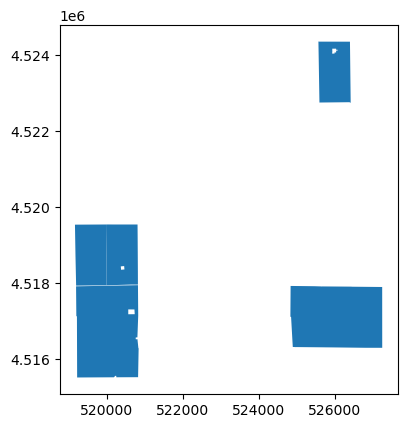

In [5]:
cper.plot()

In [6]:
cell_size = 5.0
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry.buffer(cell_size), cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)

In [7]:
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))

In [8]:
cper_xr = cper_xr.where(cper_xr != 0)

In [9]:
pts_list = []

In [10]:
from tqdm import tqdm
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            if area_thresh is not None:
                pts_tmp['area'] = pts_tmp['area'].astype('int')
                pts_tmp = pts_tmp[pts_tmp['area'] >= area_thresh]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list.append(pts_xr.where(pts_xr != 0))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


In [11]:
pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))
cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=71.176)
pts_density_xr = focal.apply(pts_all_xr,
                                    kernel, 
                                    focal._calc_sum)

/tmp/ipykernel_27978/3798738531.py:1: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


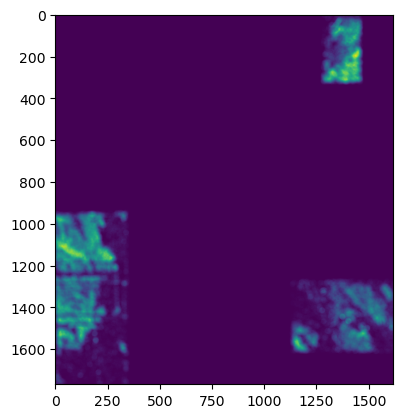

<AxesSubplot:>

In [12]:
show(pts_density_xr.data)
#pts_density_xr.isnull().all()

In [13]:
da_active =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
da_old =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()

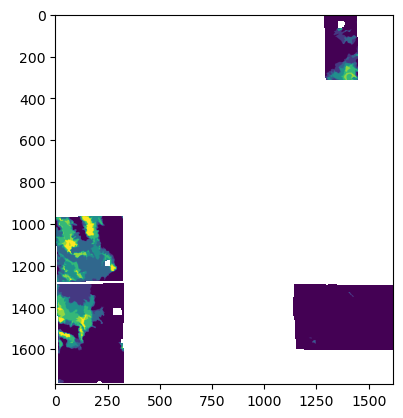

<AxesSubplot:>

In [14]:
show(da_active.data)

In [15]:
pts_density_xr = pts_density_xr.where(da_active.notnull())

In [16]:
df_active = da_active.to_dataframe(name='yrs_active')
df_old = da_old.to_dataframe(name='yrs_old')
df_pts_density = pts_density_xr.to_dataframe(name='pts_density')

In [17]:
df_out = pd.merge(pd.merge(df_active, df_old, left_index=True, right_index=True),
                  df_pts_density, left_index=True, right_index=True)

In [18]:
df_out

band_x  spatial_ref_x  yrs_active  band_y  \
y            x                                                        
4.524365e+06 519167.8595       1              0         NaN       1   
             519172.8595       1              0         NaN       1   
             519177.8595       1              0         NaN       1   
             519182.8595       1              0         NaN       1   
             519187.8595       1              0         NaN       1   
...                          ...            ...         ...     ...   
4.515525e+06 527232.8595       1              0         NaN       1   
             527237.8595       1              0         NaN       1   
             527242.8595       1              0         NaN       1   
             527247.8595       1              0         NaN       1   
             527252.8595       1              0         NaN       1   

                          spatial_ref_y  yrs_old  band  spatial_ref  \
y            x                                                        
4.524365e+06 519167.8595              0      NaN     1            0   
             519172.8595              0      NaN     1            0   
             519177.8595              0      NaN     1            0   
             519182.8595              0      NaN     1            0   
             519187.8595              0      NaN     1            0   
...                                 ...      ...   ...          ...   
4.515525e+06 527232.8595              0      NaN     1            0   
             527237.8595              0      NaN     1            0   
             527242.8595              0      NaN     1            0   
             527247.8595              0      NaN     1            0   
             527252.8595              0      NaN     1            0   

                          pts_density  
y            x                         
4.524365e+06 519167.8595          NaN  
             519172.8595          NaN  
             519177.8595          NaN  
             519182.8595          NaN  
             519187.8595          NaN  
...                               ...  
4.515525e+06 527232.8595          NaN  
             527237.8595          NaN  
             527242.8595          NaN  
             527247.8595          NaN  
             527252.8595          NaN  

[2862242 rows x 9 columns]

<AxesSubplot:xlabel='yrs_active', ylabel='pts_density'>

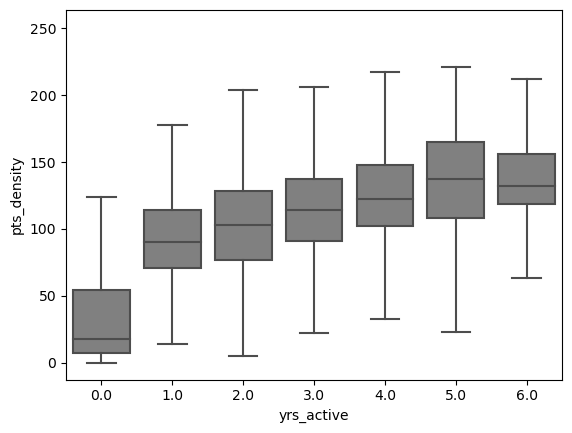

In [19]:
import seaborn as sns
sns.boxplot(x='yrs_active', y='pts_density', data=df_out, fliersize=0, color='grey')

<AxesSubplot:xlabel='yrs_active', ylabel='pts_density'>

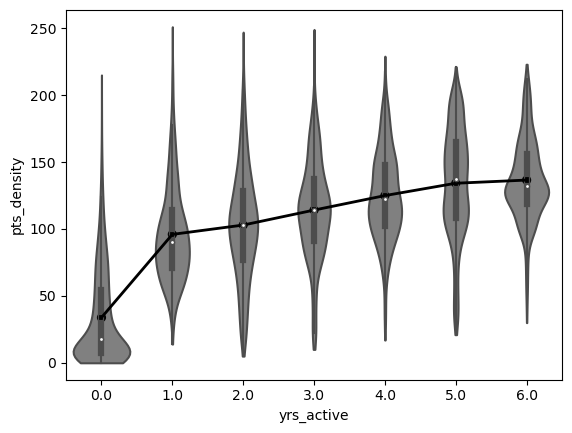

In [20]:
ax = sns.violinplot(x='yrs_active', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_active', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

<AxesSubplot:xlabel='yrs_old', ylabel='pts_density'>

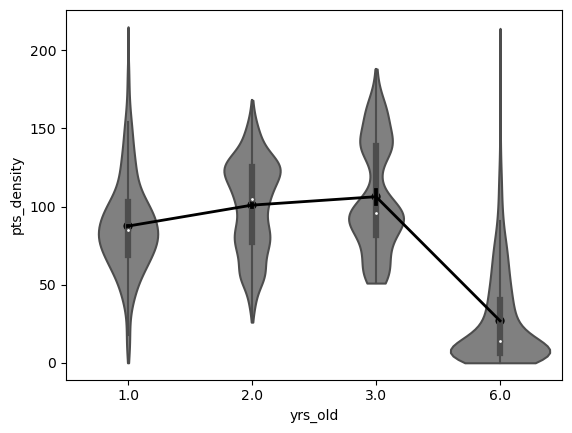

In [21]:
ax = sns.violinplot(x='yrs_old', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_old', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

In [22]:
from sklearn.metrics import jaccard_score

In [23]:
df_val = pd.DataFrame(columns=['yrs_thresh', 'pts_thresh', 'jscore'])
idx=0
for yrs_thresh in tqdm(range(0, 6)):
    for pts_thresh in range(1, 101, 2):
        df_out['y_true'] = df_out['yrs_active'] > yrs_thresh
        df_out['y_pred'] = df_out['pts_density'] > pts_thresh
        jscore = jaccard_score(y_true=df_out['y_true'],
                      y_pred=df_out['y_pred'])
        df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': yrs_thresh,
                                                  'pts_density': pts_thresh,
                                                  'jscore': jscore}, index=[idx])])
        idx+=1

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.47s/it]


In [24]:
for pts_thresh in tqdm(range(1, 101, 2)):
    df_out['y_true'] = (df_out['yrs_active'] > 0) | (df_out['yrs_old'] == 1)
    df_out['y_pred'] = df_out['pts_density'] > pts_thresh
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': -1,
                                              'pts_density': pts_thresh,
                                              'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.48it/s]


<AxesSubplot:xlabel='pts_density', ylabel='jscore'>

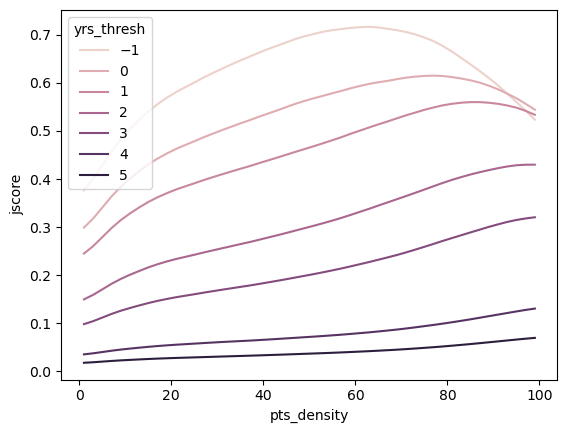

In [25]:
sns.lineplot(x='pts_density', y='jscore', data=df_val, hue='yrs_thresh')

In [26]:
df_val_smry = pd.DataFrame(df_val.groupby('yrs_thresh').apply(
    lambda x: x['pts_density'][x['jscore'] == x['jscore'].max()])).droplevel(level=1)
df_val_smry['jscore'] = df_val.groupby('yrs_thresh').apply(lambda x: x['jscore'].max())
display(df_val_smry)

,pts_density,jscore
yrs_thresh,,
-1,63.0,0.716816
0,77.0,0.615153
1,87.0,0.560076
2,99.0,0.429884
3,99.0,0.320425
4,99.0,0.130391
5,99.0,0.069431


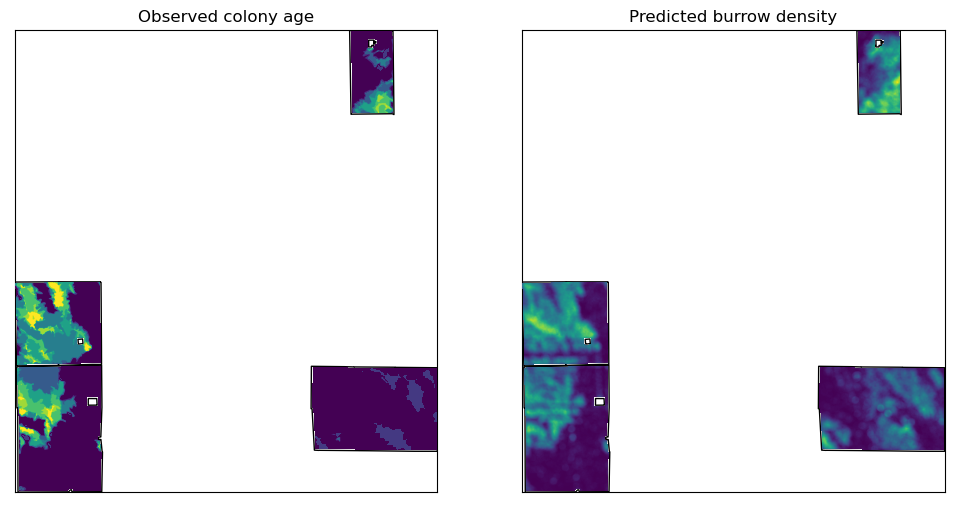

In [27]:
import matplotlib.pyplot as plt
pts_thresh = df_val_smry['pts_density'][df_val_smry.index==0][0]
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

cper.plot(fc='white', ec='black', ax=axs[0])
show(da_active.data, ax=axs[0], transform=da_active.rio.transform(), zorder=5)
show(da_old.where(da_old == 1).data, ax=axs[0], transform=da_old.rio.transform(), clim=(0, 6), zorder=8)
show(da_active.where(da_active > 0).data, ax=axs[0], transform=da_active.rio.transform(), clim=(-1, 6), zorder=10)
axs[0].set_title('Observed colony age')

cper.plot(fc='white', ec='black', ax=axs[1])
show(pts_density_xr.data, ax=axs[1], transform=pts_density_xr.rio.transform(), zorder=10)
axs[1].set_title('Predicted burrow density')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

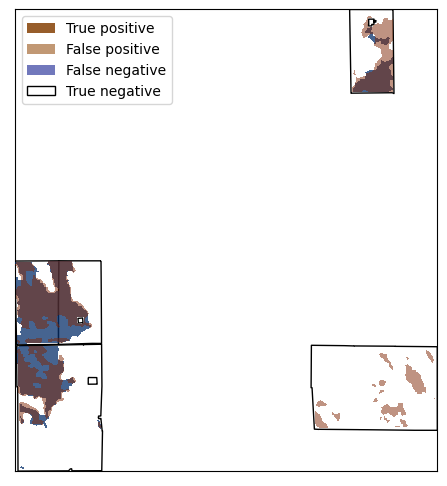

In [28]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr > pts_thresh).where(pts_density_xr > pts_thresh).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='k',
                         label='True negative')]
ax.legend(handles=legend_elements, loc='upper left')

In [29]:
print('Colony area predicted from burrow density: ')
print('  ', np.round(((pts_density_xr > pts_thresh).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round(((pts_density_xr > pts_thresh).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   386.6 ha
Colony area mapped in 2021: 
   337.8 ha
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   321.9 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha
